# NIFTY: A NON-LOCAL IMAGE FLOW MATCHING FOR TEXTURE SYNTHESIS


In [2]:
from Nifty.method import *
from Nifty.networks import *
import warnings; warnings.filterwarnings('ignore')
torch.manual_seed(0)

## Basic use:
rs:    Ratio of the reference patches to sample at each step.\
T:     Number of (linear) distretization steps between 0 and 1 to solve the flow ODE.\
k: Number of top closest patrch used to approximate the velocity field.\
octaves:   Number of diadic scales used for the synthesis\
renoise: 'time' $t_r$ used renoise the smooth upsampled image at each resolution: $x_{start}=t_r*x_{upsampled}+(1-t_r)z$. In particular, $t_r=1$ means  additional noise.\

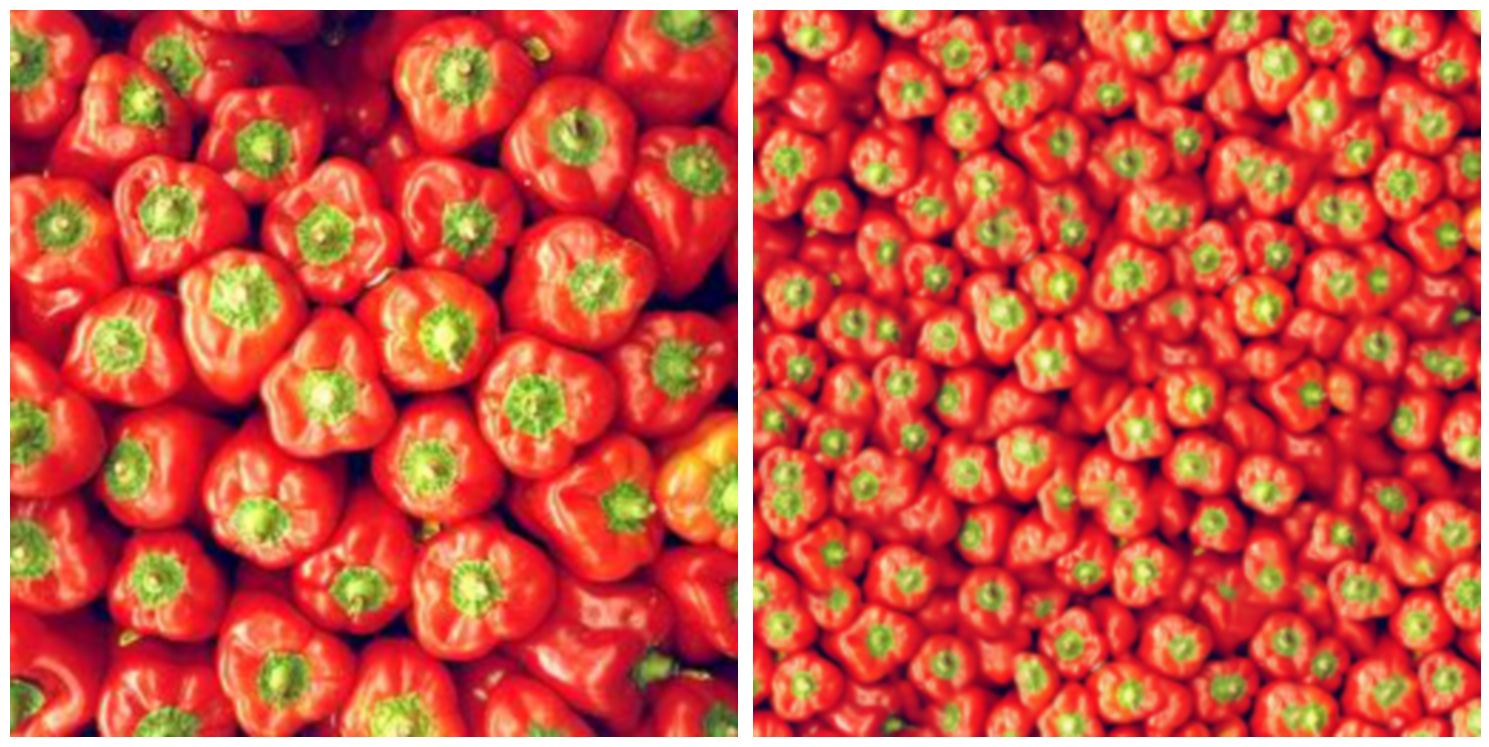

In [ ]:
img = Tensor_load('results/red_peppers.jpg')
synth= Nifty(img,rs=1,T=50,k=5,patchsize=16,stride=4,octaves=3,size=(512,512),renoise=0.5,warmup=0,memory=True,show=True)

## Visualization of patch subsampling and aggregation
We extract patches from the reference, drop 99% of them, then aggregate the patches back.\
This allows to visualize the effect of the gaussian kernel used in the aggregation step.

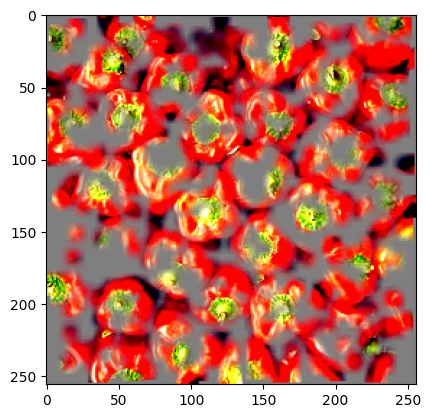

In [23]:
img = Tensor_load('results/red_peppers.jpg')
rs=.01
P_exmpl = Patch_extraction(img,patchsize=16,stride=1) # 1 x 3P^2 x HW/stride^2
N_subsampling=int(rs*P_exmpl.shape[-1])
I = torch.randperm(P_exmpl.shape[-1])
I = I[0:N_subsampling]
X = P_exmpl[:,:,I]
Y=P_exmpl*0
Y[:,:,I]=X
y=Patch_Average(Y, patchsize=16, stride=1, W=256, H=256,D=None)
y=(y[0].permute(1, 2, 0).detach().cpu()/rs*.5+.5).clamp(0,1)
plt.imshow(y)

## Copy and Creation
In this cell, we first find the nearest reference patch for each synthesized patch.\
We then plot a displacement map, where for each patch center position in the synthesis, the color encodes the position its nearest neighbor in the reference.\
This allows to observe that some large regions are copied, and from where.\
We then focus on visualizing the 'creativity' regions, stitching together copied regions.

100%|██████████| 49/49 [00:11<00:00,  4.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0000001].


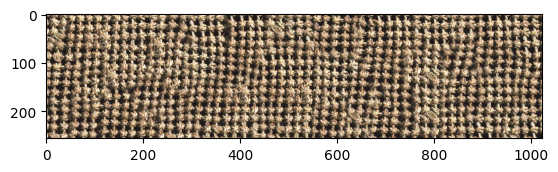

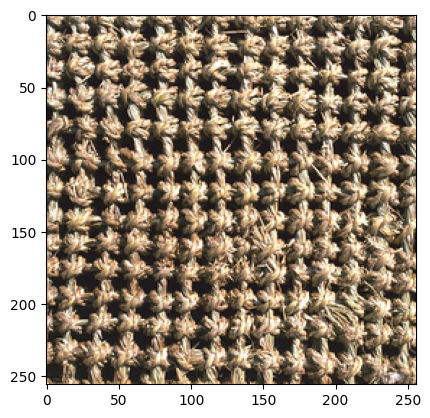

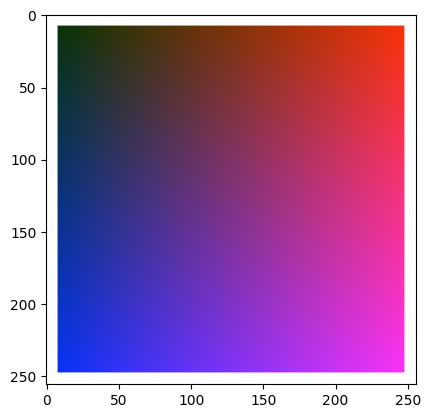

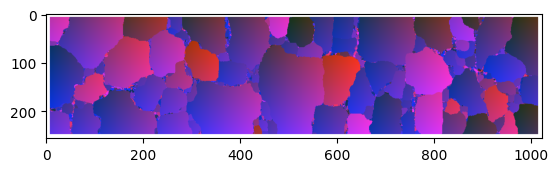

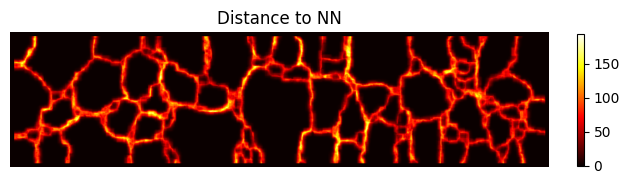

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008778065..1.0000001].


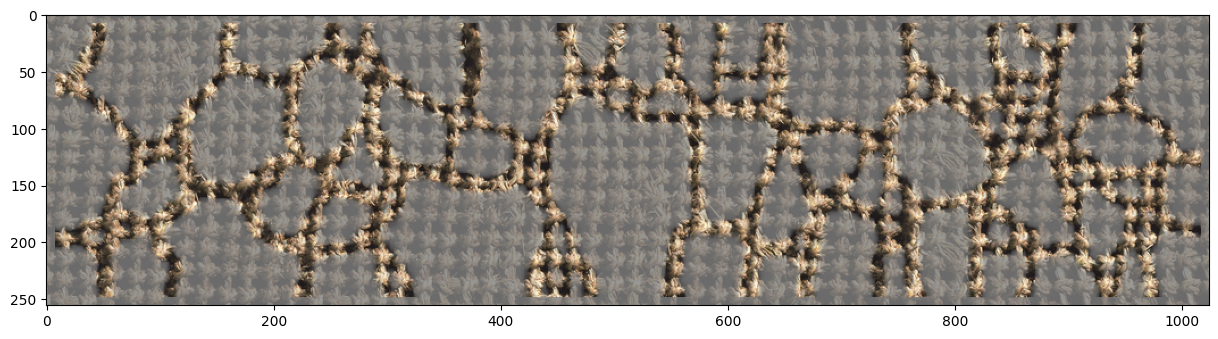

average L2 distance tensor(2.9049)


In [42]:
img = Tensor_load('comparison/eval_base/8.png')

_,_,H0,W0 = img.shape 
H,W=H0,1024
patchsize=16
stride=4

synth= Nifty(img,rs=.1,T=100,k=5,patchsize=patchsize,stride=stride,octaves=3,size=(H,W),renoise=0.5,warmup=10,memory=True,show=False) 


P_exmpl = Patch_extraction(img,patchsize=patchsize,stride=1)
P_synth = Patch_extraction(synth,patchsize=patchsize,stride=1)

N = P_synth.size(2)
ld=[]
lind=[]
for i in tqdm(range(N//5000+1)): # chunk by chunk for NN search, for memory


    X = P_exmpl[:,:,:] 
    X = X.squeeze(0)
    X2 = (X**2).sum(0).unsqueeze(0) 
    Y = P_synth[:,:,5000*i:5000*(i+1)].squeeze(0)
    Y2 = (Y**2).sum(0).unsqueeze(0) 
    D = Y2.transpose(1,0) - 2 * torch.matmul(Y.transpose(1,0),X) + X2 
    Dnn,indnn=torch.min(D,dim=1) # indnn: index of nearest ref patch for each synth patch, and Dnn the distance
    ld.append(Dnn.cpu())
    lind.append(indnn.cpu())


Dnn=torch.cat(ld)
indnn=torch.cat(lind)

y_grid = torch.linspace(0,1,H0) 
x_grid = torch.linspace(0,1,W0)
grid_y, grid_x = torch.meshgrid(y_grid, x_grid, indexing='ij')  
coords = torch.stack((grid_x,.2+0.*grid_x, grid_y), dim=0) # color map 

P_color0=Patch_extraction(coords,patchsize=patchsize,stride=1)
P_color=P_color0.view(3,patchsize,patchsize,P_color0.shape[-1])*0
P_color[:,patchsize//2,patchsize//2,:]=P_color0.view(3,patchsize,patchsize,P_color0.shape[-1])[:,patchsize//2,patchsize//2,:]
P_color=P_color.reshape(3*patchsize**2,-1)
P_warp=P_color[:,indnn] # fetch color from reference nn location
warp=nn.Fold((H,W), patchsize, dilation=1, padding=0, stride=1)(P_warp) # displacement map

P_dist=P_synth*0
P_dist=P_dist.view(3,patchsize,patchsize,P_dist.shape[-1])[:1]*0.
P_dist[0,patchsize//2,patchsize//2,:]=Dnn
dist=nn.Fold((H,W), patchsize, dilation=1, padding=0, stride=1)(P_dist.view(patchsize**2,-1))

rec=nn.Fold((H0,W0), patchsize, dilation=1, padding=0, stride=1)(P_color)

# border patches are ignored 
warp[...,:patchsize//2]=1.
warp[...,-patchsize//2:]=1.
warp[...,:patchsize//2,:]=1.
warp[...,-patchsize//2:,:]=1.

rec[...,:patchsize//2]=1.
rec[...,-patchsize//2:]=1.
rec[...,:patchsize//2,:]=1.
rec[...,-patchsize//2:,:]=1.

# compute a mask
cutoff=0.2
mask=(dist/dist.max()/cutoff)
mask[dist/dist.max()>cutoff]=1
mask=.8*mask+.2 #keep backround dimmer

novelty=synth*mask
novelty=synth*mask


plt.imshow(synth[0].permute(1,2,0).cpu()*.5+.5)
plt.show()
imsave('results/fig_synth.png',synth)

plt.imshow(img[0].permute(1,2,0).cpu()*.5+.5)
plt.show()
imsave('results/fig_ref.png',img)

plt.imshow(rec.cpu().permute(1,2,0)) # gt color
plt.show()
imsave('results/fig_gt_warp.png',rec*2-1)

plt.imshow(warp.cpu().permute(1,2,0)) # displacement map
plt.show()
imsave('results/fig_warp.png',warp*2-1)
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
im = ax.imshow(dist.cpu()[0], cmap='hot')
ax.axis('off')
cbar = fig.colorbar(im, ax=ax, fraction=0.046/W*H, pad=0.05) # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
plt.savefig('results/fig_dist.png', bbox_inches='tight', pad_inches=0) 
plt.title('Distance to NN')
plt.tight_layout()
plt.show()


plt.figure(figsize=(15,15))
plt.imshow(novelty[0].permute(1,2,0).cpu()*.5+.5)
plt.show()
imsave('results/fig_novelty.png',novelty)

print('average L2 distance',torch.cat((Dnn[Dnn>0]**.5,torch.tensor([0]*((Dnn<=0).sum())))).mean())



# Compare Nifty approximation to U-Net approximation of the flow
A U-Net is trained to learn the velocity field.\
Starting from the same noise initialization, the flow ODE is solved in identical fashion, for both velocity approxiamtions.\
The depth of the Unet is chosen so that its receptive field is approximately the same as the patch size of Nifty.\
We discard the border areas to avoid padding artifacts.


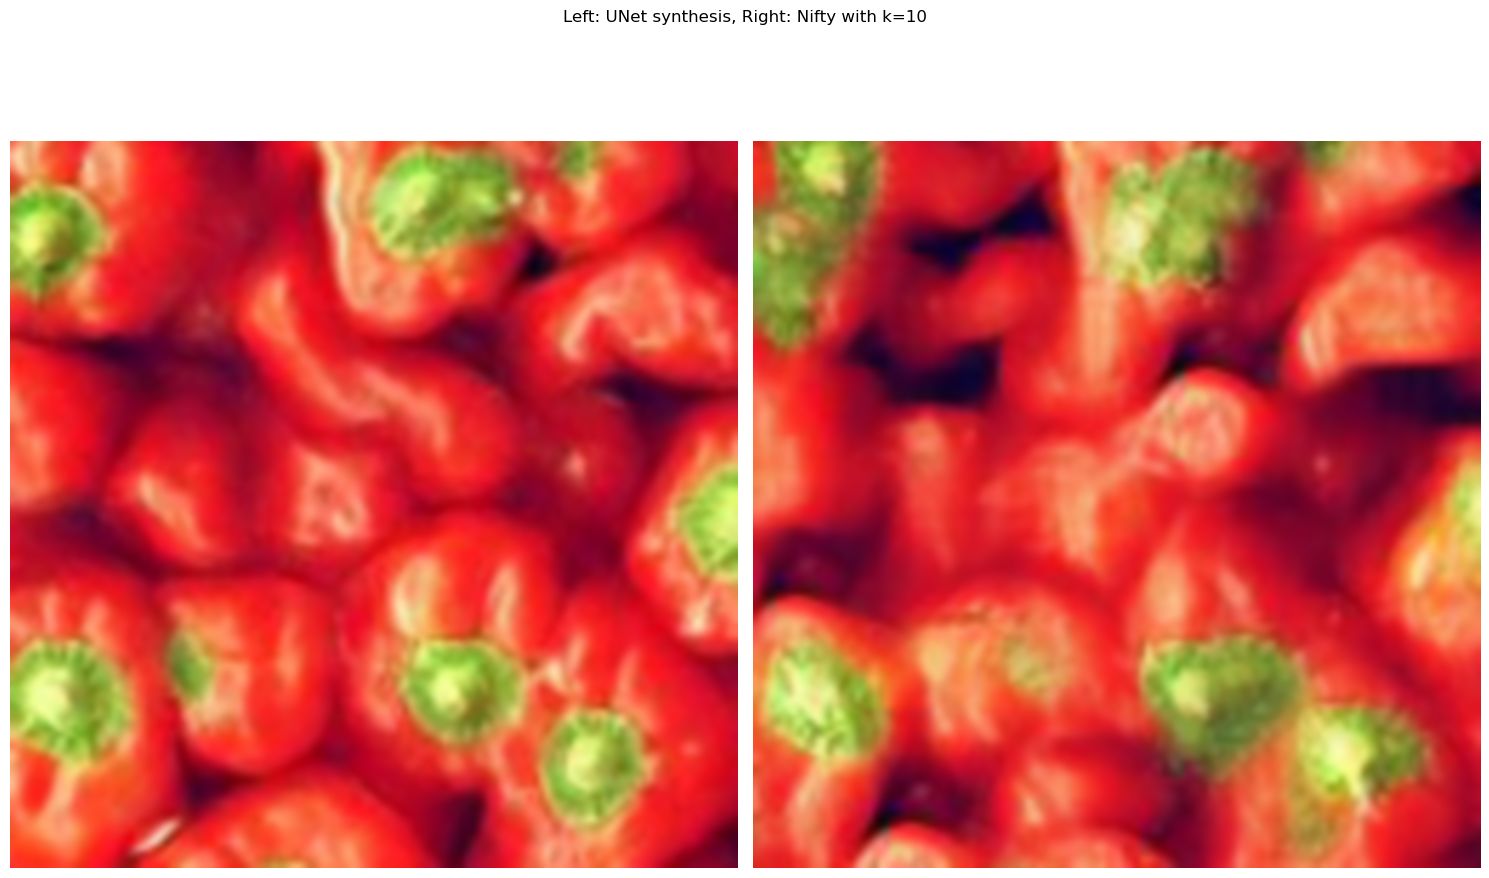

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1435.4774..90.91735].


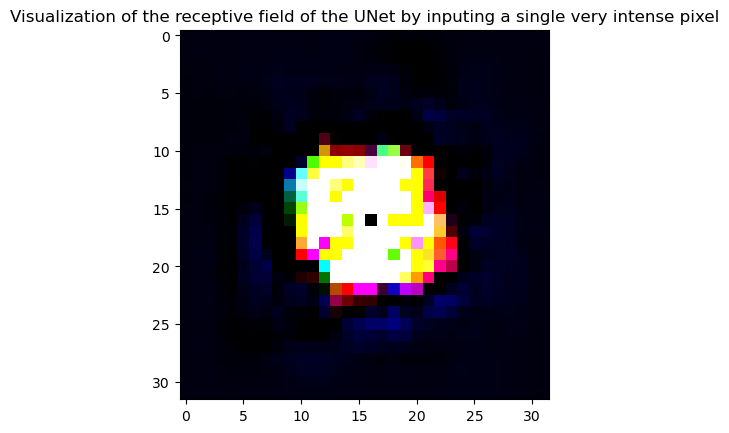

In [ ]:
from Nifty.method import *
from Nifty.networks import *
import warnings; warnings.filterwarnings('ignore')

torch.manual_seed(0)
img = Tensor_load('results/red_peppers.jpg')
mu,sigma=img.mean(),img.std()

flow_model = UNet(
        dim =64,
        dim_mults = (1, 2)).cuda()

if not os.path.exists('./results/UNet_peppers.pth'): 
    train_flow_net((img-mu)/sigma , flow_model,load=False,epochs=10000,show=False,save_name='./results/UNet_peppers.pth')

flow_model.load_state_dict(torch.load('./results/UNet_peppers.pth', map_location='cuda'))
flow_model.eval().cuda()


## NN flow


T=50
torch.manual_seed(0)
noise=torch.randn(1,3,256,256).cuda()
with torch.no_grad():
    x = noise*1.
    times=torch.linspace(0, 1, steps=T+1).cuda()
    for it in range(T):
        t=times[it]
        t = t.to(device).unsqueeze(0)
        flow = flow_model(x,t.view(1))
        x=x+flow*(times[it+1]-times[it])

synth_nn = x*sigma+mu
synth_nn=synth_nn[...,64:64+128,64:64+128]
imsave('results/synth_nn.png',synth_nn)


## Nifty fLow


lk=[10]
for k in lk:
    synth_patch=Nifty(img,rs=1,T=T,k=k,patchsize=16,stride=4,octaves=1,size=(256,256),renoise=0.5,warmup=0,memory=True,noise=noise,show=False,spotsize=1/4) 
    synth_patch=synth_patch[...,64:64+128,64:64+128]
    imsave('results/synth_patch_k_%d.png'%k,synth_patch)
    Tensor_display(synth_nn, synth_patch,s='Left: U-Net synthesis, Right: Nifty with k=%d'%k)


x0=-torch.ones(1,3,64,64).cuda()
x0[:,:,32,32]=1000
plt.figure()
plt.title('Visualization of the receptive field of the U-Net by inputing a single very intense pixel')
plt.imshow(flow_model(x0,torch.tensor(.5).view(1).cuda())[0,:,16:48,16:48].permute(1, 2, 0).detach().cpu().numpy())




## TODO

100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


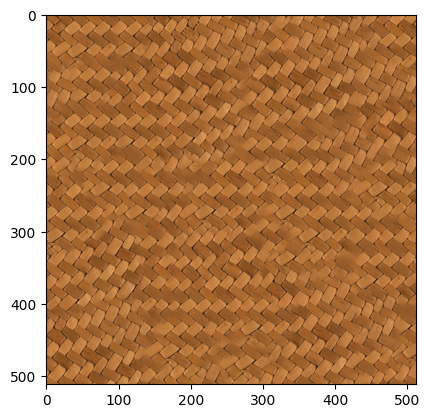

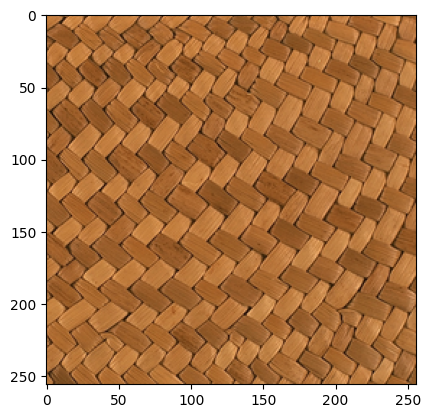

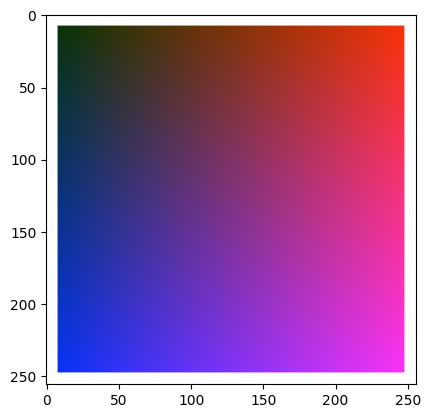

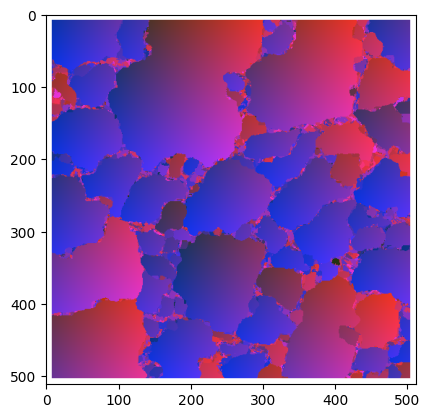

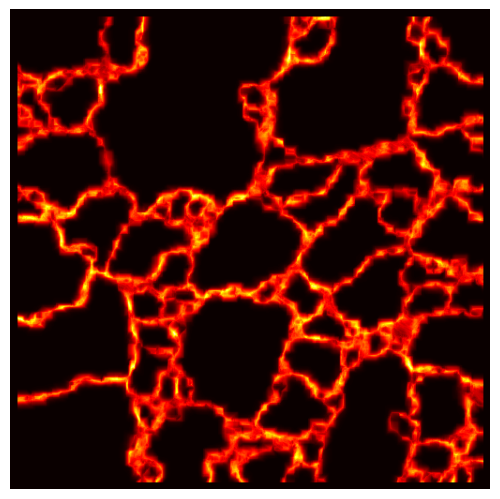

average L2 distance tensor(1.0695)


100%|██████████| 50/50 [00:03<00:00, 14.27it/s]


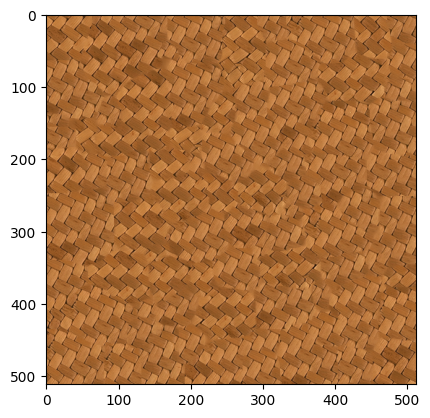

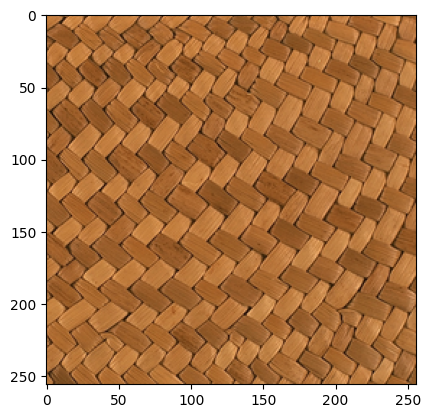

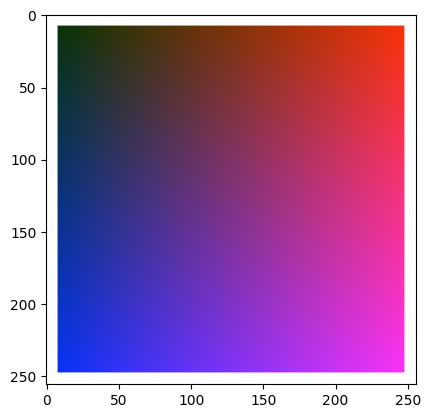

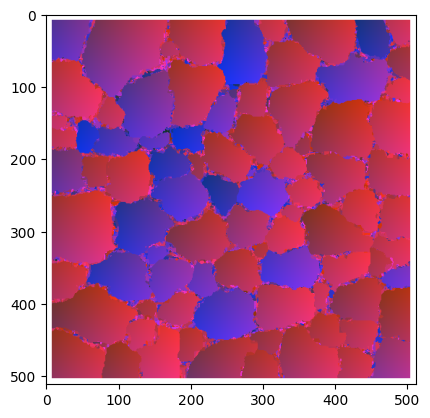

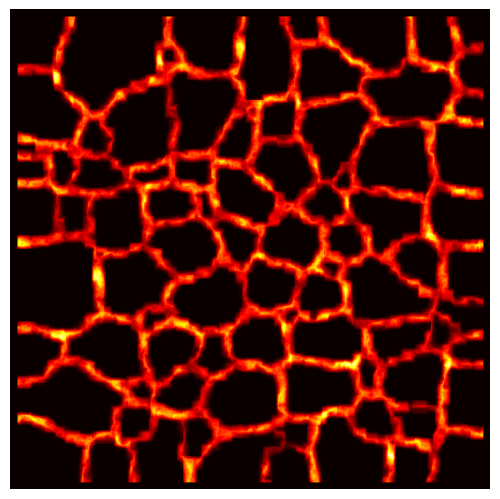

average L2 distance tensor(1.3005)


100%|██████████| 50/50 [00:03<00:00, 13.99it/s]


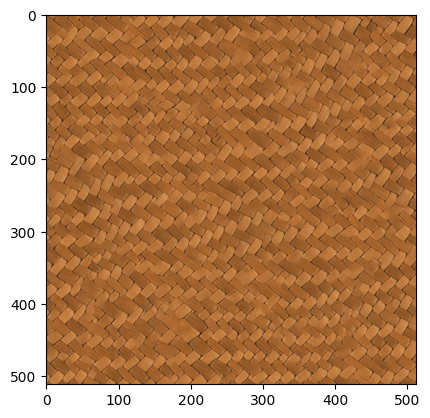

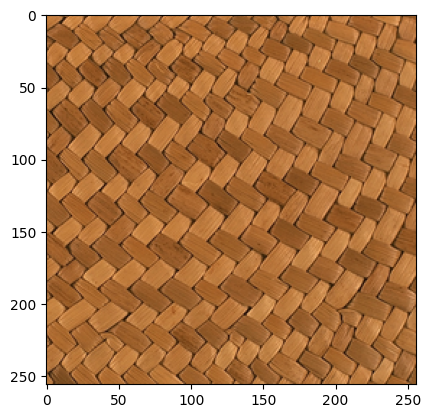

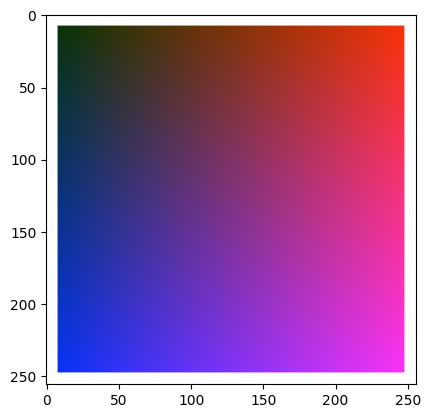

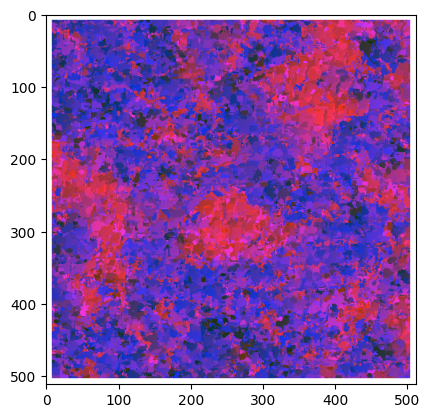

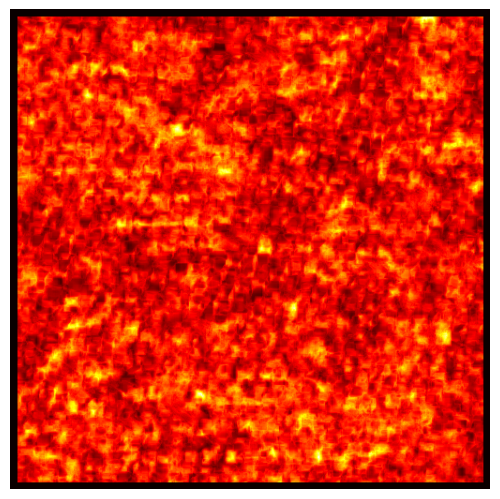

average L2 distance tensor(3.1859)


In [5]:
torch.manual_seed(0)
img_gt =  Tensor_load('results/ex_gt.png')
img_nifty = Tensor_load('results/ex_nifty.png')
img_TO = Tensor_load('results/ex_kwatra.png')
img_FM = Tensor_load('results/ex_FM.png')

patchsize=16
H0,W0=256,256
H,W=512,512

P_exmpl = Patch_extraction(img_gt,patchsize=patchsize,stride=1)
for synth,method in zip([img_nifty,img_TO,img_FM],['nifty','kwatra','FM']):
    P_synth = Patch_extraction(synth,patchsize=patchsize,stride=1)

    N = P_synth.size(2)
    ld=[]
    lind=[]
    for i in tqdm(range(N//5000+1)):


        X = P_exmpl[:,:,:] #.to(device) # 1 x d x Ns
        X = X.squeeze(0) # d x Ns

        X2 = (X**2).sum(0).unsqueeze(0) # 1 x Ns

        Y = P_synth[:,:,5000*i:5000*(i+1)].squeeze(0) # d x N

        Y2 = (Y**2).sum(0).unsqueeze(0) # squared norm : 1 x N
        D = Y2.transpose(1,0) - 2 * torch.matmul(Y.transpose(1,0),X) + X2 #N Ns
        Dnn,indnn=torch.min(D,dim=1)
        ld.append(Dnn.cpu())
        lind.append(indnn.cpu())


    Dnn=torch.cat(ld)
    indnn=torch.cat(lind)

    y_grid = torch.linspace(0,1,H0) 
    x_grid = torch.linspace(0,1,W0)
    grid_y, grid_x = torch.meshgrid(y_grid, x_grid, indexing='ij')  # H_patches x W_patches
    coords = torch.stack((grid_x,.2+0.*grid_x, grid_y), dim=0)

    P_color0=Patch_extraction(coords,patchsize=patchsize,stride=1)
    P_color=P_color0.view(3,patchsize,patchsize,P_color0.shape[-1])*0
    P_color[:,patchsize//2,patchsize//2,:]=P_color0.view(3,patchsize,patchsize,P_color0.shape[-1])[:,patchsize//2,patchsize//2,:]
    P_color=P_color.reshape(3*patchsize**2,-1)
    P_warp=P_color[:,indnn]
    warp=nn.Fold((H,W), patchsize, dilation=1, padding=0, stride=1)(P_warp)

    P_dist=P_synth*0
    P_dist=P_dist.view(3,patchsize,patchsize,P_dist.shape[-1])[:1]*0.
    P_dist[0,patchsize//2,patchsize//2,:]=Dnn/Dnn.max()
    dist=nn.Fold((H,W), patchsize, dilation=1, padding=0, stride=1)(P_dist.view(patchsize**2,-1))

    rec=nn.Fold((H0,W0), patchsize, dilation=1, padding=0, stride=1)(P_color)

    warp[...,:patchsize//2]=1.
    warp[...,-patchsize//2:]=1.
    warp[...,:patchsize//2,:]=1.
    warp[...,-patchsize//2:,:]=1.

    rec[...,:patchsize//2]=1.
    rec[...,-patchsize//2:]=1.
    rec[...,:patchsize//2,:]=1.
    rec[...,-patchsize//2:,:]=1.

    cutoff=0.2
    mask=(dist/cutoff)
    mask[dist>cutoff]=1
    mask=.8*mask+.2

    novelty=synth*mask
    novelty=synth*mask

    if True:
        plt.imshow(synth[0].permute(1,2,0).cpu()*.5+.5)
        plt.show()
        #imsave('fig_synth',synth)

        plt.imshow(img_gt[0].permute(1,2,0).cpu()*.5+.5)
        plt.show()
        #imsave('fig_ref',img_gt)

        plt.imshow(rec.cpu().permute(1,2,0))
        plt.show()
        #imsave('fig_gt_warp',rec*2-1)

        plt.imshow(warp.cpu().permute(1,2,0))
        plt.show()
        #imsave('fig_warp',warp*2-1)

        plt.imshow(dist.cpu()[0],cmap='hot')
        plt.axis('off')  # Hide axes
        plt.tight_layout(pad=0)  # Remove padding around image
        #plt.savefig('results/fig_dist.png', bbox_inches='tight', pad_inches=0)
        plt.show()

    #plt.figure(figsize=(15,15))
    #plt.imshow(torchvision.transforms.CenterCrop(128)(novelty)[0].permute(1,2,0).cpu()*.5+.5)
    #plt.show()
    #imsave('novelty_%s'%method,torchvision.transforms.CenterCrop(128)(novelty))

    print('average L2 distance',torch.cat((Dnn[Dnn>0]**.5,torch.tensor([0]*((Dnn<=0).sum())))).mean())
#imsave('novelty_%s'%'gt',torchvision.transforms.CenterCrop(128)(img_torch0))


# Texture blendig experiments

## Pixel-level blending
At each step, the (normalized) k-NN of the patches in the synthesis are computed separately for the two texture exemplars.\
The velocities are computed independently, and then linearly interpolated with parameter blend_alpha

In [ ]:
f1,f2='comparison/eval_base/7.png','comparison/eval_base/8.png'
im1 = Tensor_load(f1)
im2 = Tensor_load(f2)

blend_alpha=.6
synth= Nifty(im1,im2,rs=1.,T=50,k=10,patchsize=16,stride=4,octaves=3,size=(256,256),renoise=0.3,warmup=0,memory=True,blend=True,blend_alpha=blend_alpha,show=False) 
imsave('results/interp_pixel_space_%s_%s_%.1f.png'%(f1.split('.')[0].split('/')[-1],f2.split('.')[0].split('/')[-1],blend_alpha),synth)


## Distribution-level blending
At each step, the (normalized) k-NN are computed over the union of patches from both reference images.\
This leads to texture-homogeneous regions.

In [48]:
f1,f2='comparison/eval_base/7.png','comparison/eval_base/8.png'
im1 = Tensor_load(f1)
im2 = Tensor_load(f2)

# Implicitely 'alpha=.5'
synth= Nifty(im1,im2,rs=1.,T=50,k=10,patchsize=16,stride=4,octaves=3,size=(256,256),renoise=0.5,warmup=0,memory=True,show=False) 
imsave('results/interp_patch_distribution_%s_%s.png'%(f1.split('.')[0].split('/')[-1],f2.split('.')[0].split('/')[-1]),synth)